# Section 03
Exploring Monte Carlo methods: european options pricing 

In [1]:
import subprocess as proc
from pathlib import Path

import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme("notebook", "whitegrid", rc={"figure.dpi": 130})

from global_utils import *

## Exercise 03.1
Computing a price for the european call and put options using Monte Carlo methods. The underlying asset cost is modeled with Geometric Brownian Motion. Two sampling strategies are compared:
- direct sampling: the asset price at maturity is rolled in a single step from the initial price;
- discrete sampling: the asset price at maturity is obtained in a given number of successive samples.

Results will be compared with Black-Scholes estimates. We expect compatibility between sampling strategies, as for GBM sampling discretization is exact.

In [2]:
EX = "03_1"

# Whether to run the program or use cached results
USE_CACHED = False

# The program is run using the following parameters:
# number of blocks in the estimation procedure
N_BLOCKS = 100
# number of samples of asset prices at maturity S(T)
N_ASSET_SAMPLES = int(1e5)
# initial asset price S(0)
S0 = 100.
# strike price
K = 100.
# time of "maturity" (contract decurrence) (T)
MATURITY = 1.
# risk-free interest rate
INTEREST_RATE = 0.1
# asset price volatility
VOLATILITY = 0.25
# number of intervals for discrete sampling
N_INTERVALS = 100
# program output
OPTIONS_PATH = default_output(EX)
if not (USE_CACHED and OPTIONS_PATH.exists()):
    proc.run(
        [
            executable(EX),
            f"--primes_path={DEFAULT_PRIMES}",
            f"--seeds_path={DEFAULT_SEEDS}",
            f"--primes_line=1",
            f"--n_blocks={N_BLOCKS}",
            f"--n_simulations={N_ASSET_SAMPLES}",
            f"--n_intervals={N_INTERVALS}",
            f"--S_0={S0}",
            f"--strike_price={K}",
            f"--interest_rate={INTEREST_RATE}",
            f"--volatility={VOLATILITY}",
            f"--maturity={MATURITY}",
            f"--out={OPTIONS_PATH}",
        ]
    )

# Pandas DataFrames storing the options prices estimates
options_data = pd.read_csv(OPTIONS_PATH)

# Black-Scholes pricings
def N(x):
    return 0.5 * (1. + sp.special.erf(x / np.sqrt(2.)))

def black_scholes(S0, K, temperature, r, sigma):
    d1 = 1./(sigma * np.sqrt(temperature)) * (np.log(S0 / K) + (r + (sigma**2) / 2.) * temperature)
    d2 = d1 - sigma * np.sqrt(temperature)
    C = S0 * N(d1) - K * np.exp(-r * temperature) * N(d2)
    P = S0 *(N(d1) - 1.) - K * np.exp(-r * temperature) * (N(d2)-1.)
    return C, P


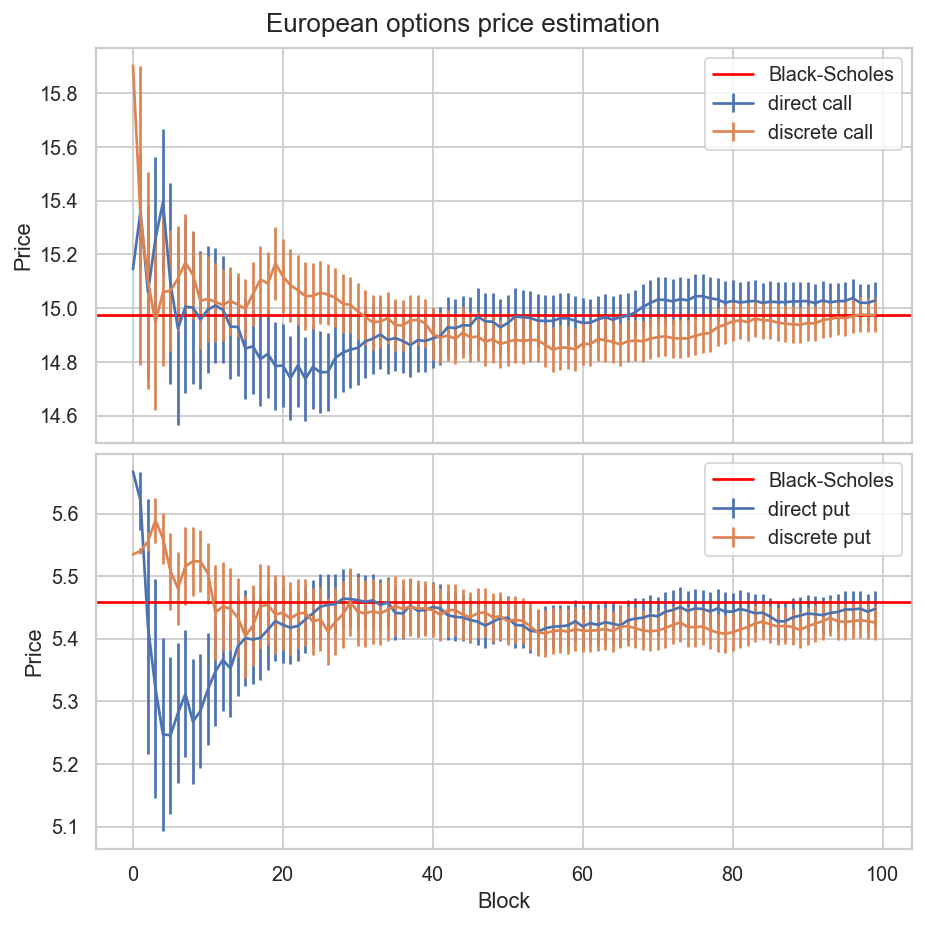

In [3]:
# Results are plotted in two images, one for each kind of option. Direct sampling vs
# discrete sampling is reported in the same image to ease the comparison
bs_results = black_scholes(S0, K, MATURITY, INTEREST_RATE, VOLATILITY)
fig, axes = plt.subplots(2, 1, sharex=True, constrained_layout=True, figsize=(7, 7))
for ax, option, bs in zip(axes.flatten(), ["call", "put"], bs_results):
    for type in ["direct", "discrete"]:
        options_data.plot.line(
            y=f"{type}_{option}_mean", yerr=f"{type}_{option}_error", label=f"{type} {option}", ax=ax
        )
    ax.axhline(bs, color="red", label="Black-Scholes")
    ax.legend()
    ax.set_ylabel("Price")
axes[1].set_xlabel("Block")
_ = fig.suptitle("European options price estimation")

The plots show correspondance between the Monte Carlo estimations (both direct and discrete) and the Black-Scholes prices. The sampling strategy doesn't seem to matter after transform warm-up period.